In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/amazon.csv')

df.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [3]:
df.shape

(2443651, 9)

## Preliminary Step: Remove outliers in product prices

For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset.
Let's start by removing the outliers and then proceed with the outlined analyses.

In [9]:
q1 = df.price.quantile(0.25)

q3 = df.price.quantile(0.75)

iqr = q3 - q1



lim_inf = q1 - 1.5 * iqr

lim_sup = q3 + 1.5 * iqr


df = df[(df.price >= lim_inf) & (df.price <= lim_sup)]

In [10]:
df.shape

(2115963, 9)

## Part 1: Analyzing Best-Seller Trends Across Product Categories

**Objective**: Understand the relationship between product categories and best sellers.
    
1. **Crosstab Analysis**:
    - Create a crosstab between the product `category` and the `isBestSeller` status.
    - Are there categories where being a best-seller is more prevalent? 
    
    
The categories with the highest proportions of best-sellers are:

- Smart Home Security & Lighting: 6.41%
- Wind Instruments: 5.93%
- Grocery: 5.81%
- Health & Personal Car: 5.7%
- Material Handling Products: 4.81%

On the other end of the spectrum, there are several categories where no products have the best-seller status.

In [11]:
df.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [13]:
cross = pd.crosstab(df.category, df.isBestSeller)

cross.head()

isBestSeller,False,True
category,,
3D Printers,36,0
3D Printing & Scanning,3251,2
Abrasive & Finishing Products,242,5
Action Cameras,1072,0
Adapters,251,3


In [18]:
cross.sort_values(by=True, ascending=False).head()

isBestSeller,False,True
category,,
Grocery,8992,555
Health & Personal Care,8990,550
Baby,14543,340
Sports & Outdoors,693779,313
Beauty,18932,301


In [21]:
cross['best_prop'] = cross[True] / (cross[True] + cross[False]) * 100

cross.sort_values(by='best_prop', ascending=False).head()

isBestSeller,False,True,best_prop
category,,,
Smart Home Security & Lighting,73,5,6.410256
Wind Instruments,111,7,5.932203
Grocery,8992,555,5.813345
Health & Personal Care,8990,550,5.765199
Material Handling Products,79,4,4.819277


2. **Statistical Tests**:
    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
    - Compute Cramér's V to understand the strength of association between best-seller status and category.
    
The Chi-square test will help us determine if there's a significant association between the product category and its best-seller status. Let's conduct the test:

In [34]:
from scipy.stats import chi2_contingency


ji2, p_valor, _ , _ = chi2_contingency(cross.drop(columns=['best_prop']))

In [35]:
ji2

32142.634946492784

In [36]:
p_valor

0.0

Given the extremely low \( p \)-value (essentially zero), we can reject the null hypothesis. This indicates that there is a significant association between the product category and its best-seller status.

**Next**, let's compute Cramér's V to understand the strength of this association.

**Cramér's V**:
Cramér's V is a measure of association between two nominal variables. Its value ranges from 0 (no association) to 1 (perfect association). Let's compute it:

In [37]:
from scipy.stats.contingency import association

association(cross.drop(columns=['best_prop']))

0.1232499362468035

The value of Cramér's V is approximately \(0.12\).

Cramér's V values can be interpreted as follows:
- \(0\): No association
- \(0.1\): Weak association
- \(0.2\): Moderate association
- \(0.3\): Relatively strong association
- \(1\): Perfect association

Given our result, the strength of association between product category and best-seller status is weak.


3. **Visualizations**:
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.
    
**Stacked Bar Chart:**
We'll visualize the relationship between product categories and their best-seller status using a stacked bar chart. To make the chart more readable, we'll focus on the top 10 categories with the highest proportions of best-sellers.

In [40]:
tabla = cross.sort_values(by='best_prop', ascending=False).head(10)

tabla

isBestSeller,False,True,best_prop
category,,,
Smart Home Security & Lighting,73,5,6.410256
Wind Instruments,111,7,5.932203
Grocery,8992,555,5.813345
Health & Personal Care,8990,550,5.765199
Material Handling Products,79,4,4.819277
Professional Medical Supplies,147,7,4.545455
"Billiard, Snooker & Pool",181,8,4.232804
Mobile Phone Accessories,244,10,3.937008
Home Brewing & Wine Making,175,7,3.846154


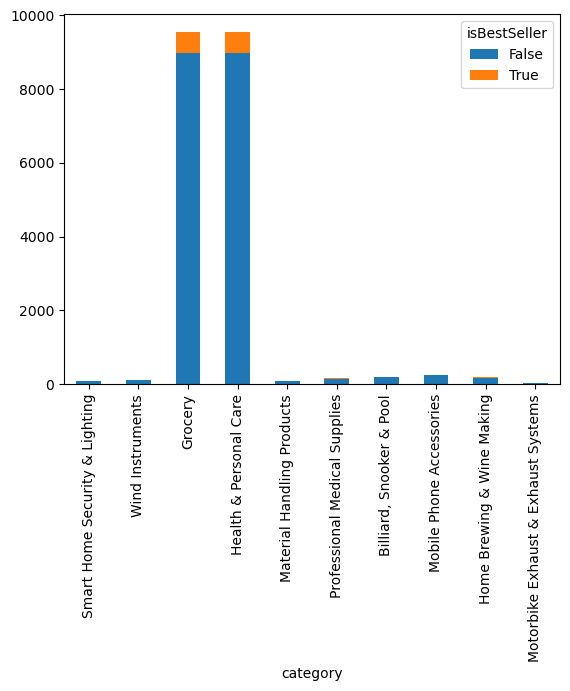

In [42]:
tabla.drop(columns=['best_prop']).plot(kind='bar', stacked=True);

Here's the stacked bar chart showcasing the top 10 categories with the highest best-seller proportions. The blue bars represent products that are not best-sellers, while the orange bars represent best-sellers.

## Part 2: Exploring Product Prices and Ratings Across Categories

**Objective**: Investigate how different product categories influence product prices.
    
1. **Violin Plots**:
- Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.
- Which product category tends to have the highest median price? Don't filter here by top categories.

In [49]:
lista_top_20 = df.category.value_counts().head(20).index

lista_top_20

Index(['Sports & Outdoors', 'Beauty', 'Bath & Body',
       'Manicure & Pedicure Products',
       'Handmade Clothing, Shoes & Accessories', 'Make-up', 'Skin Care',
       'Hair Care', 'Birthday Gifts', 'Handmade Gifts', 'Handmade Home Décor',
       'Luggage and travel gear', 'Women', 'Fragrances',
       'Handmade Kitchen & Dining', 'Handmade Artwork',
       'Handmade Home & Kitchen Products', 'Handmade Jewellery', 'Men',
       'Baby'],
      dtype='object')

In [50]:
top_20 = df[df.category.isin(lista_top_20)]

top_20.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
19513,21072,B09477KHQ3,"Personalised Birthday Print Gift ""THE YEAR YOU...",4.5,763,7.99,False,900,Handmade Home & Kitchen Products
19514,21073,B0BSRFQYG8,Wax Melts 4 Bars | Build Your Own Box (Choose ...,3.9,117,6.49,True,800,Handmade Home & Kitchen Products
19515,21074,B09N9GVHV9,"Personalised Birthday Print Gift ""ON THE DAY/Y...",4.6,1155,8.99,True,600,Handmade Home & Kitchen Products
19516,21075,B0BRYGV7PQ,Fresh Wax Melts - Laundry Type Wax Melts - Str...,4.5,56,4.99,True,500,Handmade Home & Kitchen Products
19517,21076,B0B1JHB28R,Manta Makes Work Leaving Gifts | I Used to Wor...,4.7,261,9.95,True,400,Handmade Home & Kitchen Products


In [51]:
import pylab as plt
import seaborn as sns

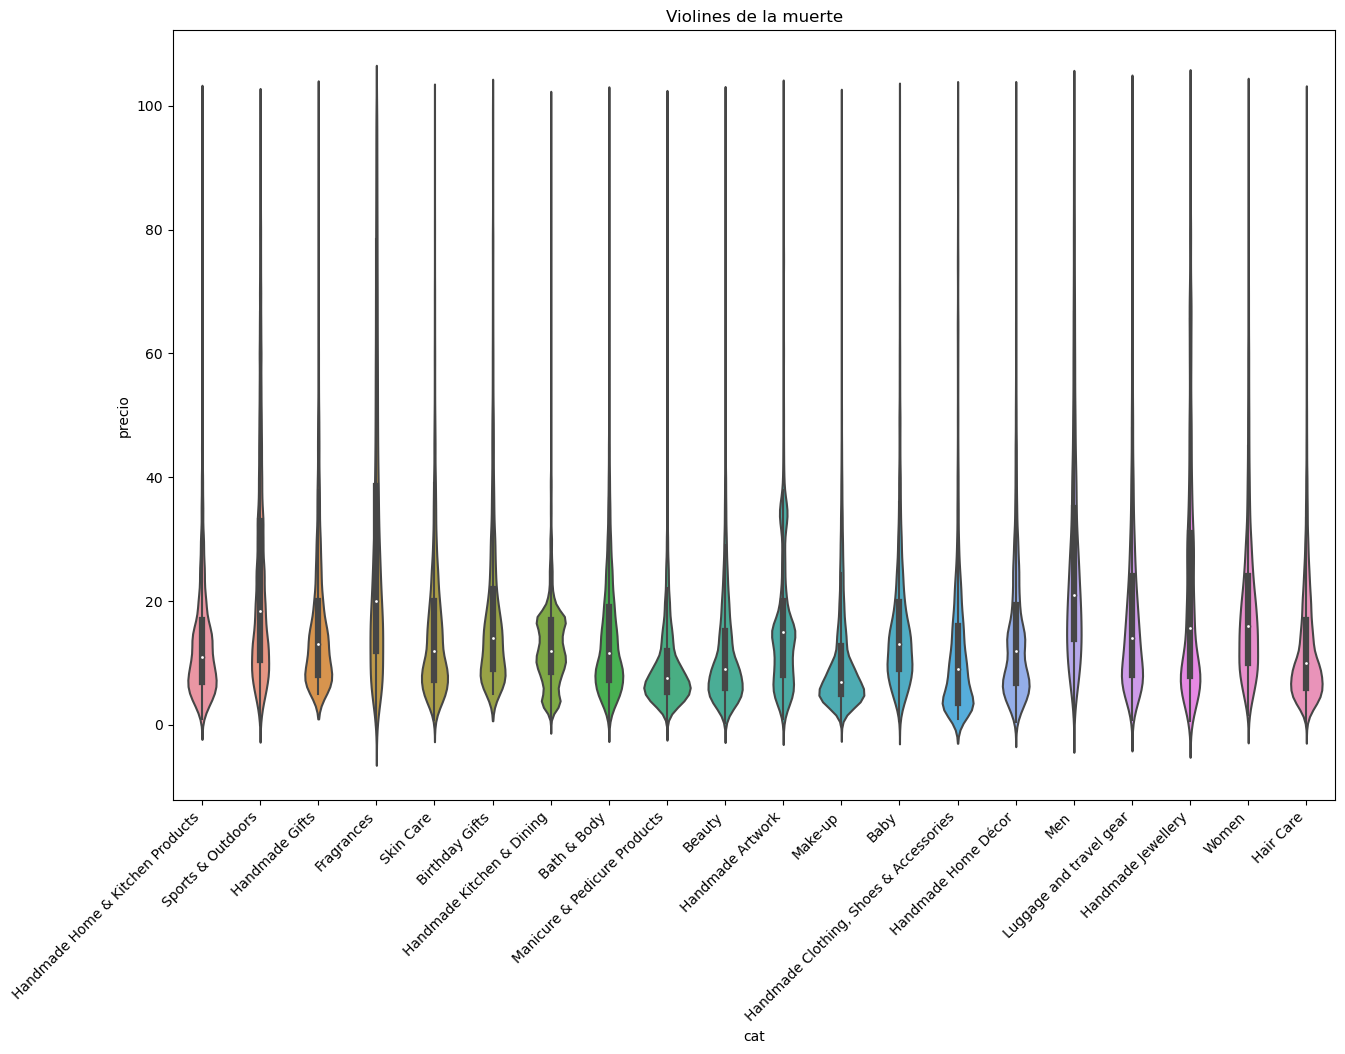

In [61]:
plt.figure(figsize=(15, 10))

plt.title('Violines de la muerte')

sns.violinplot(data=top_20, x='category', y='price')

plt.ylabel('precio')


plt.xlabel('cat')



plt.xticks(rotation=45, ha='right');

2. **Bar Charts**:
    - Create a bar chart comparing the average price of products for the top 10 product categories.
    - Which product category commands the highest average price? Don't filter here by top categories.

In [64]:
precio_medio = df.groupby('category')['price'].mean()

In [68]:
precio_medio.sort_values(ascending=False).head(10)

category
Motherboards         68.772432
Boxing Shoes         67.417803
Desktop PCs          66.915562
Tablets              66.552971
Graphics Cards       65.103509
Digital Frames       60.745129
Streaming Clients    60.241803
Hockey Shoes         60.094796
Computer Cases       58.339884
Skiing Poles         57.867770
Name: price, dtype: float64

In [70]:
lista_top_10 = df.category.value_counts().head(10).index

top_10 = df[df.category.isin(lista_top_10)]

top_10.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
82163,89483,B07DLGZ828,Neutrade GoPro 3M Sticky Pads Double Sided Adh...,4.2,3116,6.49,False,0,Sports & Outdoors
82164,89484,B09HGZHXJT,"WOLFANG Action Camera 4K 20MP GA100, Waterproo...",4.2,2594,49.99,False,0,Sports & Outdoors
82167,89487,B08LD4VXGL,FitStill 60M/196FT Waterproof Case for Go Pro ...,4.5,9879,16.98,True,0,Sports & Outdoors
82168,89488,B07QDMLMJH,Nextbase Powered Mount Variations For Cameras ...,4.7,1223,19.95,False,0,Sports & Outdoors
82169,89489,B09TQMCNY7,WOLFANG Action Camera GA100 with 64GB microSDX...,4.2,55,49.99,False,0,Sports & Outdoors


In [71]:
precio_medio = top_10.groupby('category')['price'].mean()

precio_medio.sort_values(ascending=False).head(10)

category
Sports & Outdoors                         25.172065
Birthday Gifts                            18.600195
Handmade Gifts                            17.395112
Skin Care                                 15.654722
Bath & Body                               14.678683
Hair Care                                 13.461408
Handmade Clothing, Shoes & Accessories    12.958639
Beauty                                    12.523480
Make-up                                   10.612918
Manicure & Pedicure Products              10.231825
Name: price, dtype: float64

In [72]:
tabla = precio_medio.sort_values(ascending=False).head(10)

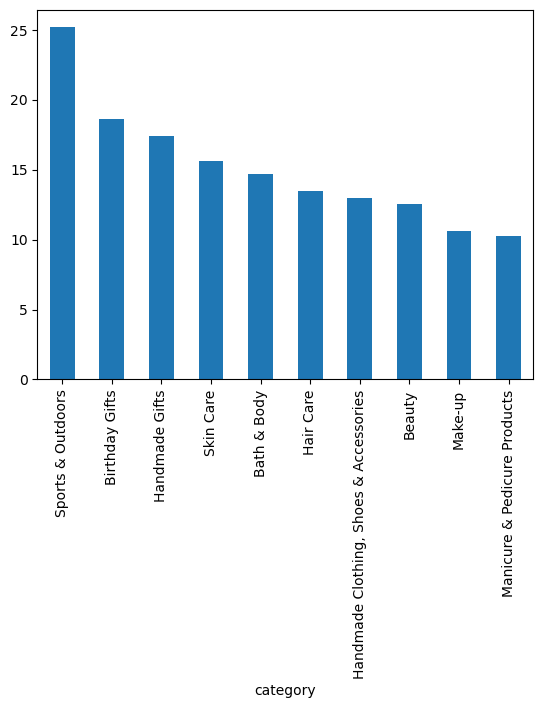

In [73]:
tabla.plot(kind='bar');

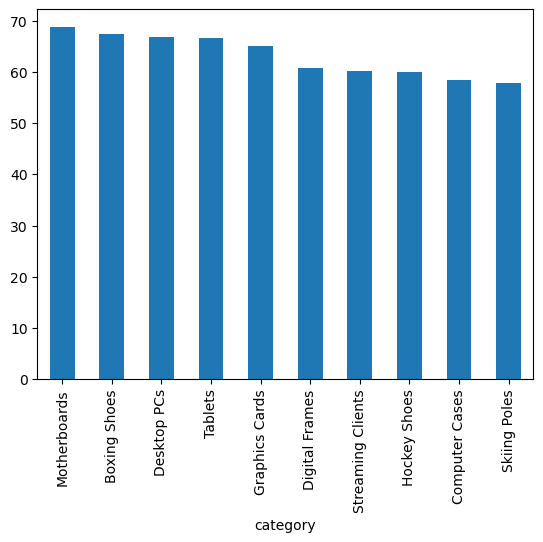

In [76]:
df.groupby('category')['price'].mean().sort_values(ascending=False).head(10).plot(kind='bar');

3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

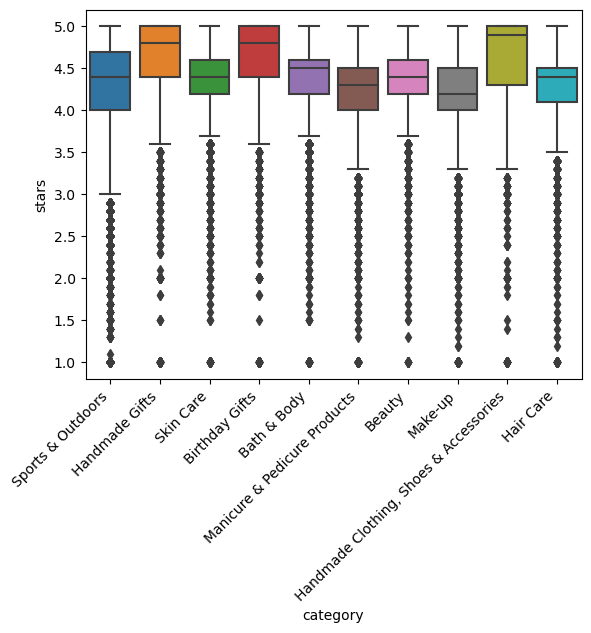

In [80]:
sns.boxplot(data=top_10[top_10.stars>0], x='category', y='stars')

plt.xticks(rotation=45, ha='right');

## Part 3: Investigating the Interplay Between Product Prices and Number of Reviews

**Objective**: Analyze how product number of reviews correlate with product prices.
    
1. **Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `reviews`.
    - Is there a significant correlation between product price and its number of reviews?

In [83]:
df.price.corr(df.reviews, method='pearson')

-0.008497583007235946

In [84]:
df.price.corr(df.reviews, method='spearman')

-0.07812705877522293

In [85]:
df.price.corr(df.reviews, method='kendall')

/opt/homebrew/Caskroom/miniconda/base/envs/clase/lib/python3.9/site-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


-0.05599327746669491

This value is close to zero, indicating a very weak negative correlation between product price and the number of reviews.

Practically, this suggests that the price of a product and the number of reviews it has are largely independent of each other, with only a slight negative trend.

Other factors (e.g., product quality, brand reputation, customer expectations) likely play a more significant role.

2. **Visualizations**:
    - Use a scatter plot to visualize the relationship between product reviews and price. What patterns can you observe?
    - Use a correlation heatmap to visualize correlations between `price`, `reviews`, and other continuous variables.
    - Examine if product prices typically follow a normal distribution using a QQ plot. 

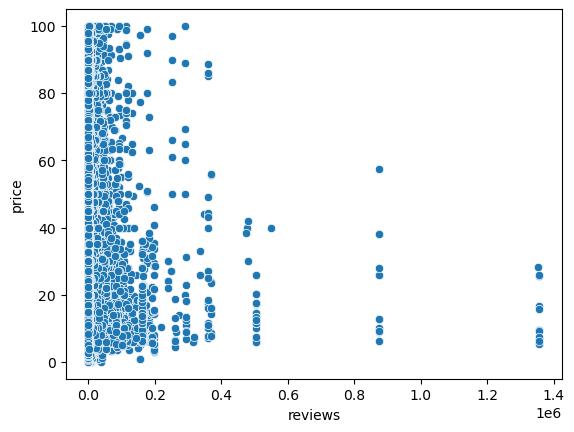

In [86]:
sns.scatterplot(x=df.reviews, y=df.price);

In [87]:
df.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [88]:
df.price.corr(df.stars, method='pearson')

-0.07767299878181444

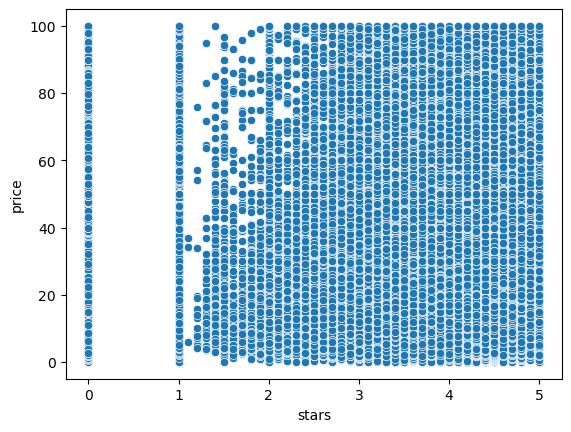

In [89]:
sns.scatterplot(x=df.stars, y=df.price);

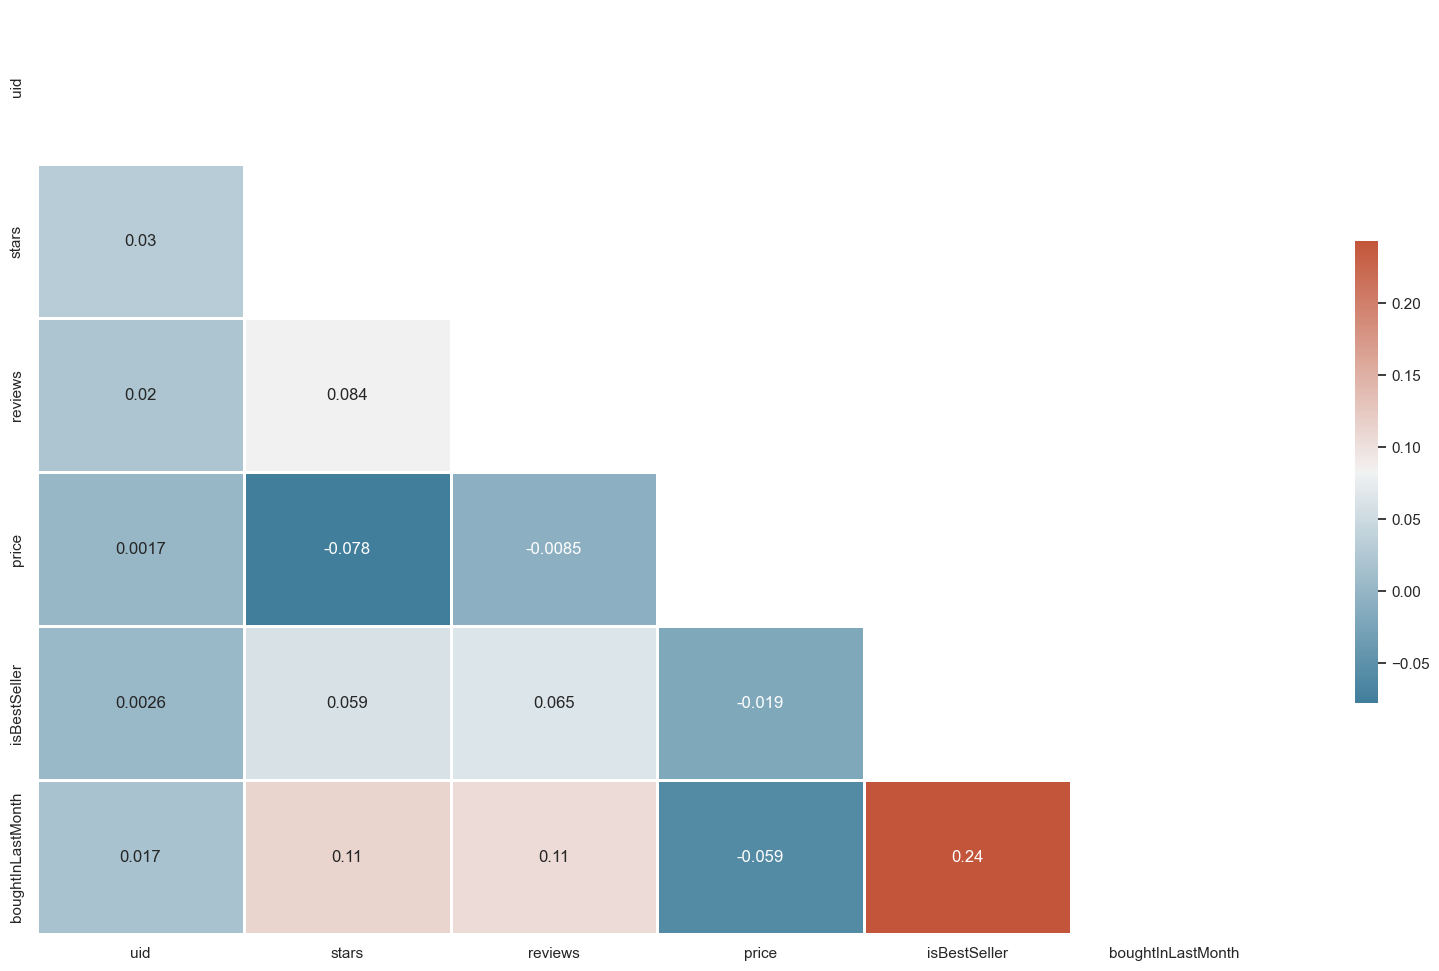

In [90]:
import numpy as np

sns.set_theme(style="white")


# Compute the correlation matrix
corr = df.corr(numeric_only=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            annot=True,
            linewidths=.8, 
            cbar_kws={"shrink": .5}
           );

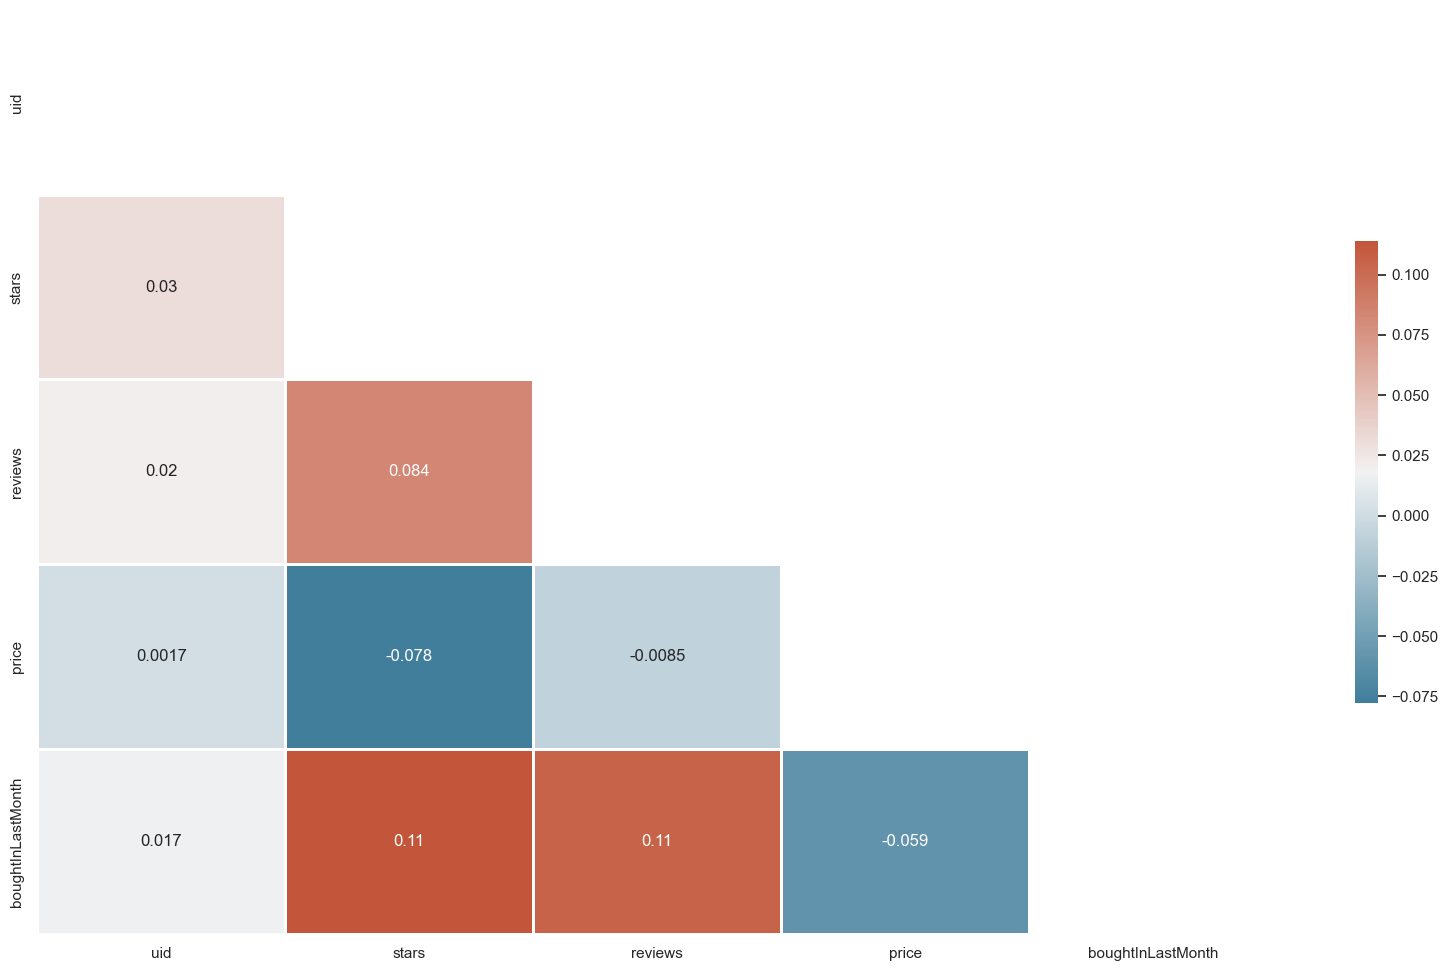

In [91]:
sns.set_theme(style="white")


# Compute the correlation matrix
corr = df.select_dtypes('number').corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            annot=True,
            linewidths=.8, 
            cbar_kws={"shrink": .5}
           );

In [92]:
import scipy.stats as stats

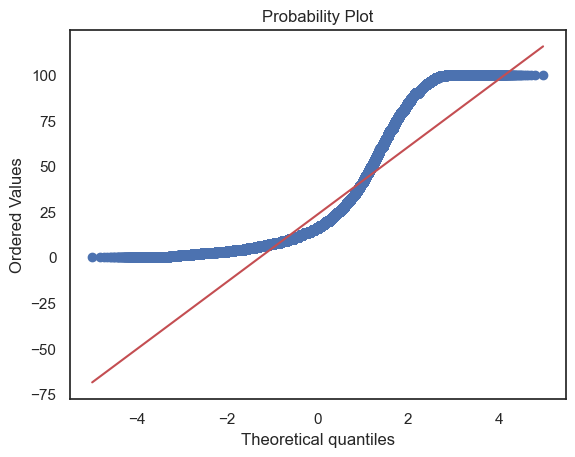

In [98]:
stats.probplot(df.price, dist='norm', plot=plt);

**QQ Plot for Product Prices**:
   - A QQ (quantile-quantile) plot is used to compare the distribution of a dataset with a theoretical normal distribution.
   - If the data points in the QQ plot closely follow the straight line (which represents the normal distribution), then the dataset is approximately normally distributed.
   - In this case, the QQ plot indicates that product prices are not  normally distributed.

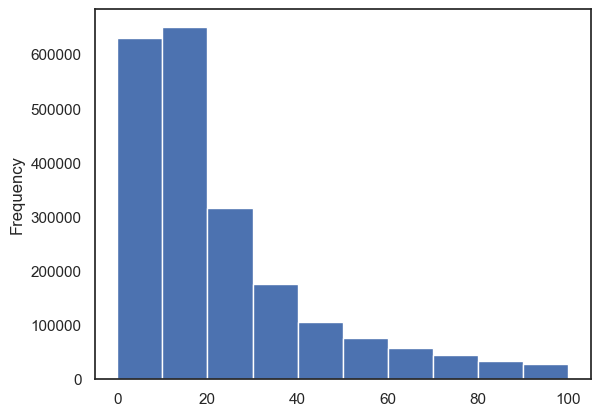

In [97]:
df.price.plot(kind='hist');